# Popular Data Science Questions

Our goal in this project is to use the Data Science Stack Exchange (DSSE) site to determine the type of content a data science education company should create. We will use the site's subjects to determine what seems most interesting to data scientists and use that to promot our project.


Before we begin, let's explore some details around a Stack Exchange website:

**What kind of questiosn are welcome on this site?**

Revieiwng the help center for DSSE, we can see that we should:

- Avoid subjective questions
- Ask practical questions about Data Science
- Ask specific questions
- Make questions relevant to others

We also found that there are a few additional sites that could be relevant for us:

Open Data and Computational Science

**What, other than questions, does the site's home subdivide into?**

The front page appears to have four additional pages under the side menu: Questions, Tags, Users and Unanswered

The Tags seem to be useful for the problem we hope to solve. We will be able to see how many questionsget asked for each subject.

**What information is available in each post?**

For questions, we see:
- Views
- Title
- Author
- Question
- Number of users who tagged it
- Last time the question was active
- Score
- Related questions
- Tags within the question

For answers:
- Score
- Title
- Author
- Answer

Reviewing the first page of questions and tags, we see a number of questions about selecting proper models and optimizing models. We also see some statistics questions and typical coding questions.

For topics, we see:
- machine-learning
- python
- neural-network
- deep-learning
- classification
- keras
- scikit-learn
- tensorflow
- nlp
- r

## Getting the data

Stack Exchange luckily provides a public database for each website. We can use their own query site to gather what we need using Transact-SQL. The `Posts` table seems most promising with details about the tags as well as details of the questions and scoring.

Based on the data provided in this table, we can see that the volume of posts outside of questions and answers is relatively small. We will focus on questions and will limit out questions to those posted in 2019, helping us to focus on recent topics.


Using the query generator, we can gather relevant data with the following query and store it as a file called `2019_questions.csv`.
```t-sql
SELECT ID, CreationDate,
       Score, ViewCount, tags
       AnswerCount, FavoriteCount
FROM   posts
WHERE  PostTypeId = 1 AND YEAR(CreationDate) = 2019
```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
questions = pd.read_csv('2019_questions.csv', parse_dates=['CreationDate'])

In [3]:
questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


In [4]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


Looking through the dataset, it appears that the only column with missing values is `AnswerCount`. This row is missing data for 7,432 out of 8,839 rows. If a value is missing for this, it probably just means it did not exist on anyone's favorite list. All nulls should be easily replace with zeros.

All column types seem fine except `AnswerCount`. There should be no reason to store a count as a float. After filling in the nulls, we'll convert to an integer.

The `Tags` column is a bit messy. We'll do some minor character cleaning, but will keep things as a list.

In [5]:
questions.fillna(value={'FavoriteCount': 0}, inplace=True)
questions['FavoriteCount'] = questions['FavoriteCount'].astype(int)
questions.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object

In [6]:
questions['Tags'] = questions['Tags'].str.replace('^<|>$', '').str.split('><')
questions.head(10)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,"[machine-learning, data-mining]",0,0
1,44420,2019-01-23 09:34:01,0,25,"[machine-learning, regression, linear-regressi...",0,0
2,44423,2019-01-23 09:58:41,2,1651,"[python, time-series, forecast, forecasting]",0,0
3,44427,2019-01-23 10:57:09,0,55,"[machine-learning, scikit-learn, pca]",1,0
4,44428,2019-01-23 11:02:15,0,19,"[dataset, bigdata, data, speech-to-text]",0,0
5,44430,2019-01-23 11:13:32,0,283,[fuzzy-logic],1,0
6,44432,2019-01-23 11:17:46,1,214,"[time-series, anomaly-detection, online-learning]",0,1
7,44436,2019-01-23 12:49:39,0,9,[matrix-factorisation],0,0
8,44437,2019-01-23 13:04:11,0,7,"[correlation, naive-bayes-classifier]",0,0
9,44438,2019-01-23 13:16:29,0,584,"[machine-learning, python, deep-learning, kera...",1,0


To start looking at the popularity of tags, we'll look at two different things:

1. How many times each tag was used
2. How many times each tag was viewed

In [7]:
tag_count = {}
for tags in questions['Tags']:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

In [8]:
tag_count = pd.DataFrame.from_dict(tag_count, orient='index')
tag_count.rename(columns={0: 'Count'}, inplace=True)
tag_count.sort_values(by='Count', ascending=False)

,Count
machine-learning,2693
python,1814
deep-learning,1220
neural-network,1055
keras,935
classification,685
tensorflow,584
scikit-learn,540
nlp,493
cnn,489


We can see the most popular tags above. Funny enough, the tags listed on home page seem to be the top tags listed here.

Let's look at the top 20 as the counts seem to drop beyond that.

In [9]:
most_used = tag_count.sort_values(by='Count', ascending=False).head(20)

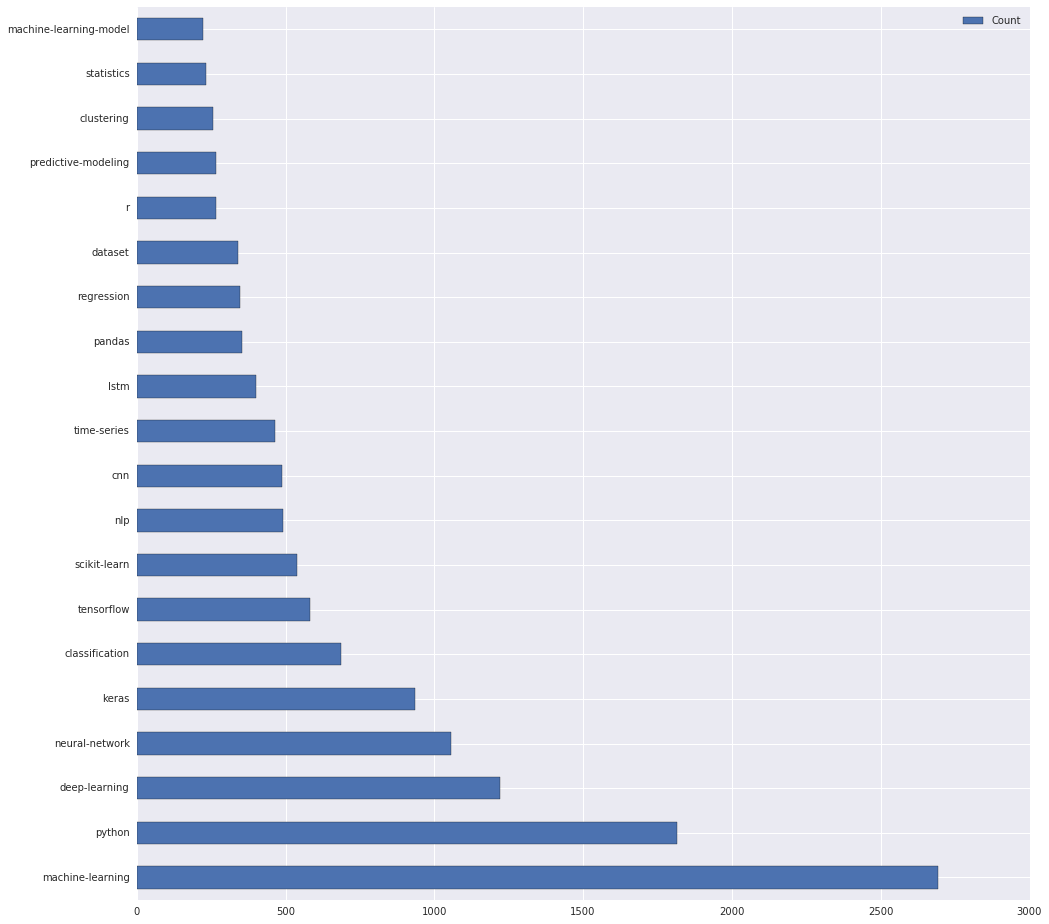

In [10]:
most_used.plot(kind='barh', figsize=(16,16))

In [11]:
tag_views = {}

for i, tags in enumerate(questions['Tags']):
    for tag in tags:
        if tag in tag_views:
            tag_views[tag] += questions['ViewCount'].iloc[i]
        else:
            tag_views[tag] = 1
            
tag_views = pd.DataFrame.from_dict(tag_views, orient='index')
tag_views.rename(columns={0: 'ViewCount'}, inplace=True)

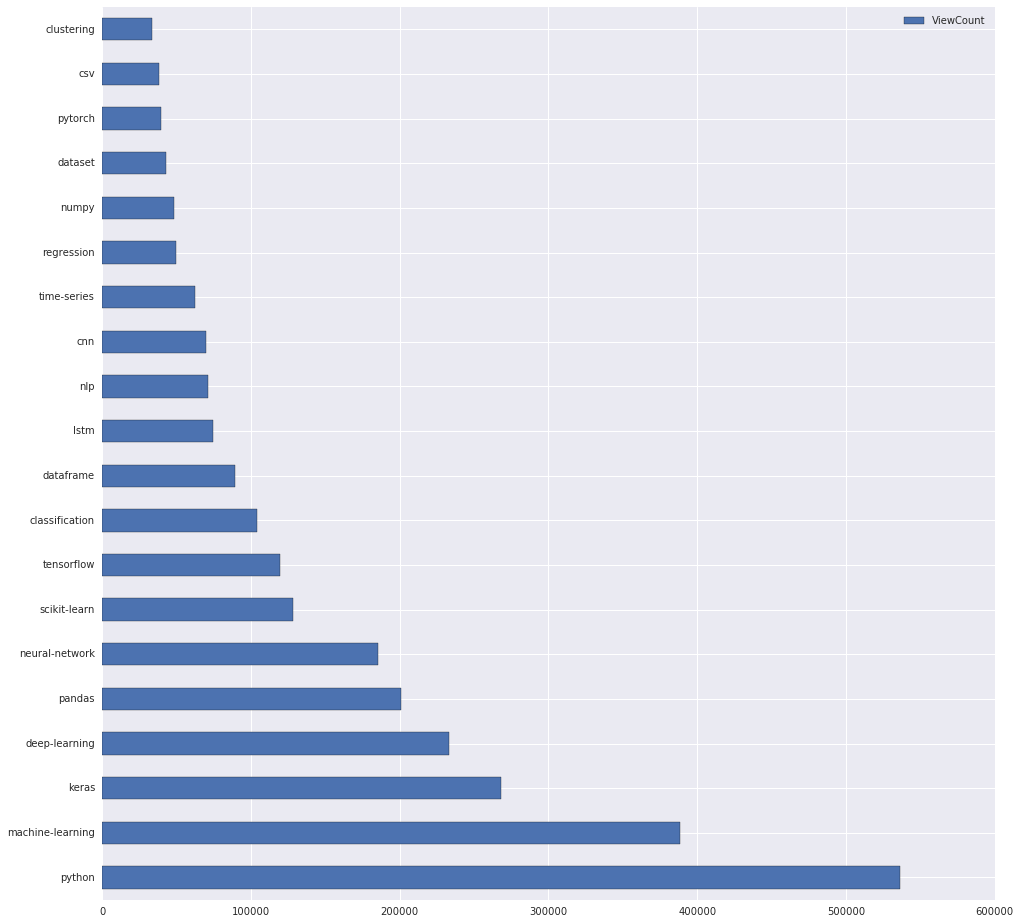

In [12]:
most_viewed = tag_views.sort_values(by='ViewCount', ascending=False).head(20)
most_viewed.plot(kind='barh', figsize=(16,16))

In [13]:
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)
print(in_used[in_used['ViewCount'].isna()])
print(in_viewed[in_viewed['Count'].isna()])

                        Count  ViewCount
r                         268        NaN
predictive-modeling       265        NaN
statistics                234        NaN
machine-learning-model    224        NaN
           Count  ViewCount
dataframe    NaN      89281
numpy        NaN      48556
pytorch      NaN      39887
csv          NaN      38453


We can see that of the tags used, the four that don't appear in the top lists of viewed are `r`, `predictive-modeling`, `statistics` and `machine-learning-model`. Similarly, the tags in our top list of views, but not in our top list of used tags are `dataframe`, `numpy`, `pytorch` and `csv`.

## How can we relate tags?

If we only consider pairs of tags, we can quickly see correlations in a 2D table. Let's do this.

In [14]:
all_tags = list(tag_count.index)
pairs = pd.DataFrame(index=all_tags, columns=all_tags)
pairs

,data-product,non-convex,inceptionresnetv2,search-engine,lightgbm,image-classification,lasso,lbp,embeddings,outlier,...,gridsearchcv,terminology,javascript,probability,rmse,probability-calibration,etl,dump,orange,objective-function
data-product,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
non-convex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inceptionresnetv2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
search-engine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lightgbm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
image-classification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lasso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lbp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
embeddings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
outlier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We need to fill this. As we would do with most counts, let's set each cell to 0 and then increment when we see a pair.

In [15]:
pairs.fillna(0, inplace=True)
pairs

,data-product,non-convex,inceptionresnetv2,search-engine,lightgbm,image-classification,lasso,lbp,embeddings,outlier,...,gridsearchcv,terminology,javascript,probability,rmse,probability-calibration,etl,dump,orange,objective-function
data-product,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
non-convex,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
inceptionresnetv2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
search-engine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lightgbm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
image-classification,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lasso,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lbp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
embeddings,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
outlier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
for tags in questions['Tags']:
    pairs.loc[tags, tags] += 1

Since this is a huge list, let's look at our top 20 lists. Let's focus in on the most used list and look for pairs.

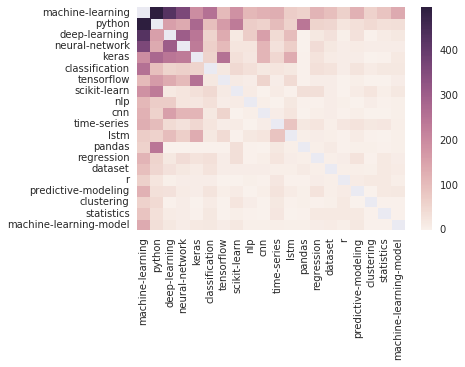

In [17]:
pairs_most_used = pairs.loc[most_used.index, most_used.index]
for i in range(pairs_most_used.shape[0]):
    pairs_most_used.iloc[i,i] = pd.np.NaN
sns.heatmap(pairs_most_used, annot=False)

By zeroing out the pairs of matching values which are of little relevance, but 100% correlation, we can see the strongest pairs. We can see some stronger correlations, but when you consider the topic pairs such as machine-learning and python or deep-learning or neural-network, it may not tell us as much. Machine-learning is broad and can encompass any of those others. 

There are additional ways to look at correlations and causality of certain tags to others, but probably outside of the scope of this analysis.

Domain knowledge can be very useful for us in analyzing the topics and their benefit to us.

Looking at the top 10 tags from viewed and used, we find these topics in common. Here are the meanings of each:

1. Python - programming language commonly used for data analysis and machine learning modeling. It has grown significantly in popularity.
2. Machine-learning - programmatic algorithms commonly used in data science to better understand and analyze large sets of data
3. Deep-learning - a method of machine learning that has become very popular
4. Neural-network - another machine learning method that has become veyr popular
5. Keras - a Python library for deep learning
6. Tensorflow - a Python library for deep learning
7. classification - A type of modeling used with machine learning, specifically looking at classifying distinct results
8. scikit-learn - a Python library used for all sorts of machine learning modeling.

## Is deep learning just a fad?

Many of the top tags appear to be related to the concept of deep learning. While this seems to be popular, we also want to make sure it isn't just a topic that was popular and is slowing down now.

We'll be using a file that holds all results from DSSE returned from the following query:

```t-sql
SELECT Id, CreationDate, Tags
FROM posts
WHERE PostTypeId = 1;
```

In [18]:
all_qs = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])

In [19]:
all_qs.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,<python><keras><tensorflow><cnn><probability>
1,45418,2019-02-12 00:50:39,<neural-network>
2,45422,2019-02-12 04:40:51,<python><ibm-watson><chatbot>
3,45426,2019-02-12 04:51:49,<keras>
4,45427,2019-02-12 05:08:24,<r><predictive-modeling><machine-learning-mode...


In [20]:
all_qs['Tags'] = all_qs['Tags'].str.replace('^<|>$', '').str.split('><')

Based on our list of top tags related to deep learning and a few others, we'll label all of the following tags as related to deep learning:

- lstm
- cnn
- scikit-learn
- tensorflow
- keras
- neural-network
- deep-learning

In [21]:
def classify_dl_tags(tags):
    for tag in tags:
        if tag in ['lstm', 'cnn', 'scikit-learn', 'tensorflow',
                  'keras', 'neural-network', 'deep-learning']:
            return 1
        else:
            return 0
        
all_qs['dltags'] = all_qs['Tags'].apply(classify_dl_tags)
all_qs.head()

,Id,CreationDate,Tags,dltags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",0
1,45418,2019-02-12 00:50:39,[neural-network],1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0
3,45426,2019-02-12 04:51:49,[keras],1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0


Considering how quickly, or slowly, these topics in data science change, let's look at the topics quarterly. Let's also drop 2020, since we're not quite through a quarter in 2020 yet.

In [24]:
all_qs = all_qs[all_qs['CreationDate'].dt.year < 2020]

def get_quarter(date):
    year = str(date.year)
    quarter = '0' + str(((date.month-1) // 3) + 1)
    return '{}{}'.format(year,quarter)

all_qs['quarter'] = all_qs['CreationDate'].apply(get_quarter)

In [25]:
all_qs.head()

,Id,CreationDate,Tags,dltags,quarter
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",0,201901
1,45418,2019-02-12 00:50:39,[neural-network],1,201901
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0,201901
3,45426,2019-02-12 04:51:49,[keras],1,201901
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0,201901


Let's now try to answer the following questions:
- How many deep learning questions are asked per quarter?
- How many total questions were asked per quarter?
- How many deep learning questions are there relative to the total number of questions per period?

In [28]:
quarterly_qs = all_qs.groupby('quarter').agg({'dltags': ['sum', 'size']})
quarterly_qs.columns = ['dl_qs', 'total_qs']
quarterly_qs['dl_freq'] = quarterly_qs['dl_qs']/quarterly_qs['total_qs']
quarterly_qs.reset_index(inplace=True)
quarterly_qs.head()

,quarter,dl_qs,total_qs,dl_freq
0,201402,3,157,0.019108
1,201403,4,189,0.021164
2,201404,4,216,0.018519
3,201501,5,190,0.026316
4,201502,6,284,0.021127


We should be able to answer all of our questions in one chart.

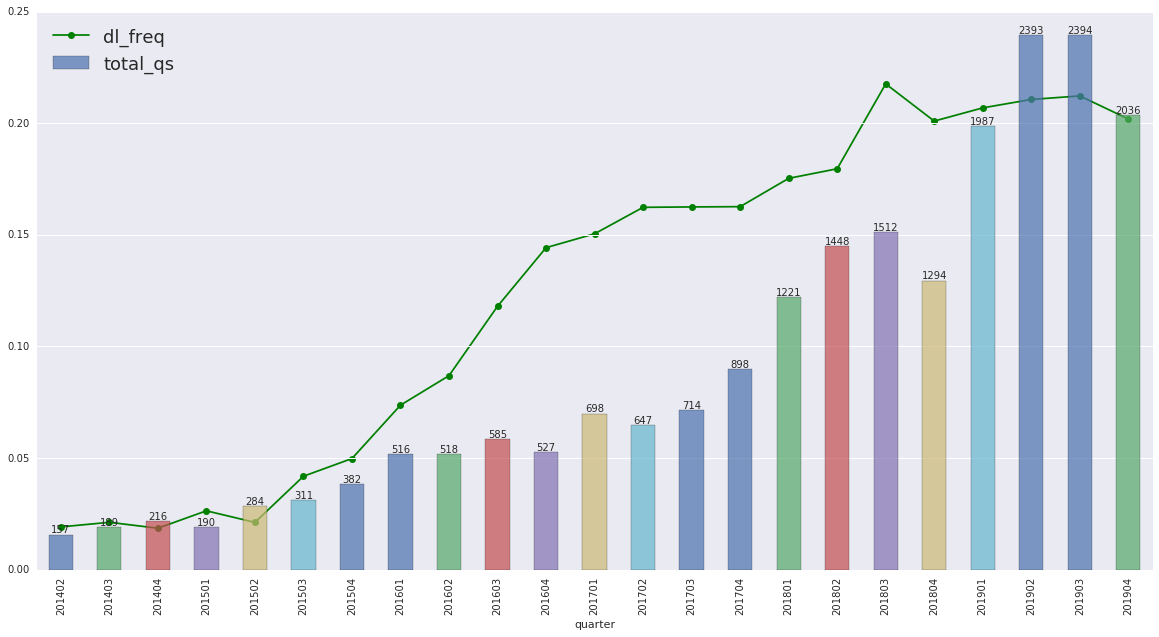

In [32]:
ax1 = quarterly_qs.plot(x='quarter', y='dl_freq',
                       kind='line', linestyle='-', marker='o',
                       color='green', figsize=(20, 10))

ax2 = quarterly_qs.plot(x='quarter', y='total_qs',
                       kind='bar', ax=ax1, secondary_y=True,
                       alpha=0.7, rot=90)

for i, t in enumerate(quarterly_qs['total_qs']):
    ax2.text(i, t, str(t), ha='center', va='bottom')
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1+handles2,
          labels=labels1+labels2,
          loc='upper left', prop={'size': 18})

for ax in (ax1, ax2):
    for where in ('top', 'right'):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

To answer our original questions, we can see the total number of questions asked each quarter, the percentage of those that were related to deep learning and we can calculate the number of deep learning questions by multiplying the frequency by the total number of questions.

We also see that deep learning greq heavily up until Q3 of 2018 and has leveled some since then, but still seems to be a popular topic without any indication that it will decrease soon. It would still be a good idea for us to focus our content on deep learning.